Using device: cuda

Epoch 1/5
 [██████████████████████████████] 100.0%
Loss: 145.3156

Epoch 2/5
 [██████████████████████████████] 100.0%
Loss: 141.1221

Epoch 3/5
 [██████████████████████████████] 100.0%
Loss: 140.9358

Epoch 4/5
 [██████████████████████████████] 100.0%
Loss: 140.5987

Epoch 5/5
 [██████████████████████████████] 100.0%
Loss: 139.2671
Test Accuracy: 0.6391
F1 Score     : 0.5787
Precision    : 0.6968
Recall       : 0.4949


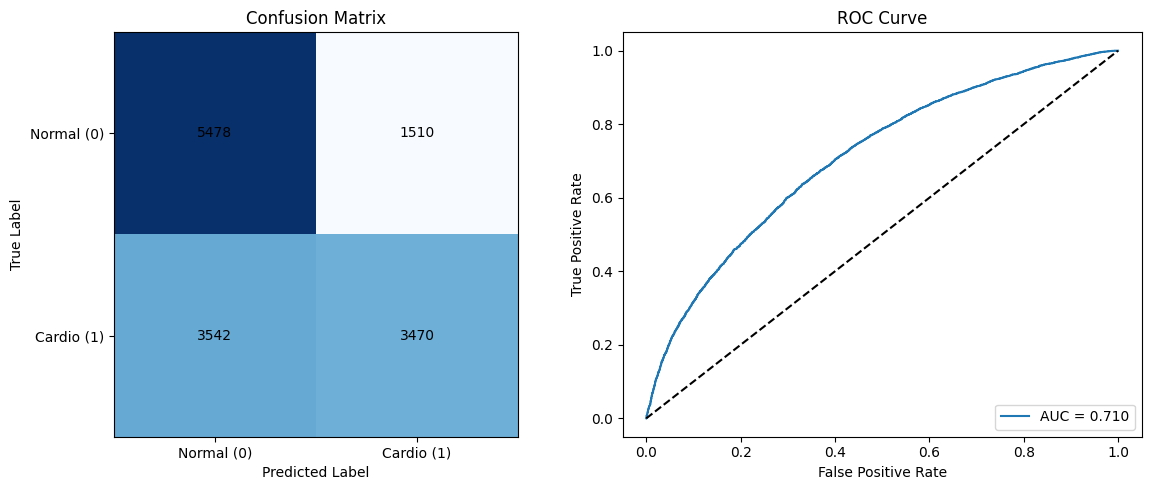

In [19]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 1. データ読み込み（セミコロン区切り）
data = pd.read_csv("cardio_train.csv", sep=';') 

# 2. 特徴量の指定
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
continuous_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
target_col = 'cardio'

# 3. カテゴリ変数を数値化（LabelEncoder）
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# 4. 連続値を正規化（平均0, 標準偏差1）
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

# 5. 訓練/テストに分割
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 6. PyTorch Dataset定義
class CardioDataset(Dataset):
    def __init__(self, dataframe):
        self.categorical_data = dataframe[categorical_cols].values.astype(np.int64)
        self.continuous_data = dataframe[continuous_cols].values.astype(np.float32)
        self.labels = dataframe[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.categorical_data[idx]),
            torch.tensor(self.continuous_data[idx]),
            torch.tensor(self.labels[idx])
        )

train_dataset = CardioDataset(train_data)
test_dataset = CardioDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

# 7. TabTransformerモデル構築
cont_mean_std = torch.tensor([[0.0, 1.0]] * len(continuous_cols))  # 標準化済みなので (mean=0, std=1)

model = TabTransformer(
    categories=(2, 3, 3, 2, 2, 2),  # 各カテゴリのユニーク数
    num_continuous=5,
    dim=32,
    dim_out=1,
    depth=4,
    heads=4,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2),
    mlp_act=nn.ReLU(),
    continuous_mean_std=cont_mean_std
)
model = model.to(device)

model.categories_offset = model.categories_offset.to(device)


# 8. 損失関数・最適化手法
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 9. 学習ループ
def train_model(model, loader, epochs=5):
    model.train()
    total_batches = len(loader)

    for epoch in range(epochs):
        total_loss = 0.0
        print(f"\nEpoch {epoch+1}/{epochs}")
        for batch_idx, (x_categ, x_cont, y) in enumerate(loader):
            x_categ = x_categ.to(device)  # ←追加
            x_cont = x_cont.to(device)    # ←追加
            y = y.to(device)              # ←追加
            optimizer.zero_grad()
            out = model(x_categ, x_cont).squeeze(1)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # 進捗表示
            progress = (batch_idx + 1) / total_batches * 100
            bar_len = 30
            filled_len = int(bar_len * progress / 100)
            bar = '█' * filled_len + '-' * (bar_len - filled_len)
            sys.stdout.write(f"\r [{bar}] {progress:5.1f}%")
            sys.stdout.flush()

        print(f"\nLoss: {total_loss:.4f}")

# 10. 評価関数
def evaluate_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x_categ, x_cont, y in loader:
            x_categ = x_categ.to(device)
            x_cont = x_cont.to(device)
            y = y.to(device)
            out = model(x_categ, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()

            preds.extend(pred.cpu().tolist())
            trues.extend(y.int().cpu().tolist())

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds)
    precision = precision_score(trues, preds)
    recall = recall_score(trues, preds)

    print(f"Test Accuracy: {acc:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    return acc, f1, precision, recall

# 11. 実行
train_model(model, train_loader, epochs=5)
evaluate_model(model, test_loader)

# 混同行列を計算して表示する関数
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_and_roc(model, loader):
    model.eval()
    preds, trues, probs = [], [], []

    with torch.no_grad():
        for x_categ, x_cont, y in loader:
            x_categ = x_categ.to(device)  # ←追加
            x_cont = x_cont.to(device)    # ←追加
            y = y.to(device)              # ←追加
            out = model(x_categ, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()

            preds.extend(pred.tolist())
            trues.extend(y.int().tolist())
            probs.extend(prob.tolist())

    # 混同行列
    cm = confusion_matrix(trues, preds)
    classes = ['Normal (0)', 'Cardio (1)']

    # ROC
    fpr, tpr, _ = roc_curve(trues, probs)
    auc = roc_auc_score(trues, probs)

    # 描画
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 1. 混同行列
    axs[0].imshow(cm, cmap='Blues')
    axs[0].set_xticks(np.arange(len(classes)))
    axs[0].set_yticks(np.arange(len(classes)))
    axs[0].set_xticklabels(classes)
    axs[0].set_yticklabels(classes)
    axs[0].set_xlabel("Predicted Label")
    axs[0].set_ylabel("True Label")
    axs[0].set_title("Confusion Matrix")

    for i in range(len(classes)):
        for j in range(len(classes)):
            axs[0].text(j, i, cm[i, j], ha="center", va="center", color="black")

    # 2. ROC曲線
    axs[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC Curve")
    axs[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# 実行
plot_confusion_and_roc(model, test_loader)
